In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import xarray as xr
import os 
import shutil


p = Path(".")
root_folder = p.cwd().parent 
git_data_folder = root_folder/   'git_data'
gen_data_folder = git_data_folder / 'gen_forecasts' 
scripts_foler = root_folder/ 'scripts'
outside_data_folder = root_folder / 'outside_data'
power_gen_data_folder = outside_data_folder / 'power_gen_data'
gen_data_folder = git_data_folder / 'gen_forecasts'
historical_load_folder = git_data_folder / 'historical_load'
load_forecast_folder = git_data_folder / 'load_forecasts_updated'

scratch_folder = root_folder  / 'scratch'

In [13]:
root_folder

PosixPath('/Users/justinmaynard/Documents/GitHub/assetraMP/examples/pjm_run')

In [2]:
#Replace with file path for this directory on your machine
!pip install -e /Users/justinmaynard/Documents/GitHub/assetraMP/ 


Obtaining file:///Users/justinmaynard/Documents/GitHub/assetraMP
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for assetra (pyproject.toml) ... done
  Created wheel for assetra: filename=assetra-1.0.3-py3-none-any.whl size=2689 sha256=dbec1acd386afa31ce06d71424f177f8781dc8432d27f26b9e6f1bc595d1c07a
  Stored in directory: /private/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/pip-ephem-wheel-cache-3ty5pm2r/wheels/c0/f5/c9/3b09bf7f2c6beadc5d6cde6ca7e50094804a4b90493c211e80
Successfully built assetra
  Attempting uninstall: assetra
    Found existing installation: assetra 1.0.3
    Uninstalling assetra-1.0.3:
      Successfully uninstalled assetra-1.0.3


In [3]:
def is_leap_year(year):
    """Returns True if the year is a leap year, otherwise False."""
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

def load_pjm_cleaned_hourly_demand(
        pjm_demand_file: Path,
        start_hour: datetime,
        end_hour: datetime) -> xr.DataArray:
    """Return hourly demand data as formatted data array.
    To use this function, download cleaned demand data from:

    https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data

    Args:
        pjm_demand_file (Path): Path to hourly demand file
        start_hour (datetime): First timestamp to include
        end_hour (datetime): Last timestamp to include (inclusive)

    Returns:
        xr.DataArray: Hourly demand array with time dimension and datetime coordinates.
    """
    # Read demand file
    pjm_demand_df = pd.read_csv(
        pjm_demand_file,
        usecols=["datetime_beginning_ept", "mw"],
        parse_dates=["datetime_beginning_ept"],
    )

    demand_year = pjm_demand_df['datetime_beginning_ept'].dt.year.unique()[0]
    weather_year = pd.to_datetime(start_hour).year

    # Update year for all timestamps
    pjm_demand_df['datetime_beginning_ept'] = pjm_demand_df['datetime_beginning_ept'].apply(
        lambda x: x.replace(year=weather_year)
    )

    # Handle leap years

    if not is_leap_year(demand_year) and is_leap_year(weather_year):
        # Create February 29th entries by copying February 28th values
        feb_28_mask = pjm_demand_df['datetime_beginning_ept'].dt.strftime('%m-%d') == '02-28'
        feb_28_entries = pjm_demand_df[feb_28_mask].copy()

        # Update the datetime to be February 29th
        feb_28_entries['datetime_beginning_ept'] = feb_28_entries['datetime_beginning_ept'] + pd.Timedelta(days=1)

        # Append February 29th data to the DataFrame
        pjm_demand_df = pd.concat([pjm_demand_df, feb_28_entries], ignore_index=True)

        # Sort data just in case
        pjm_demand_df = pjm_demand_df.sort_values('datetime_beginning_ept')

    pjm_demand_df.set_index('datetime_beginning_ept', inplace=True)

    # Keep cleaned demand data within the specified time range
    pjm_hourly_demand_pd = pjm_demand_df["mw"].loc[start_hour:end_hour]

    # Convert to xarray DataArray
    pjm_hourly_demand = xr.DataArray(
        data=pjm_hourly_demand_pd.values,
        coords=dict(time=pjm_hourly_demand_pd.index.values)
    )

    return pjm_hourly_demand


In [4]:
def determine_new_class(storage_file_initial_yr, storage_file_previous_yr):
    storage_file_initial = pd.read_csv(storage_file_initial_yr)
    storage_file_new = pd.read_csv(storage_file_previous_yr)
    new_rows = storage_file_initial.merge(storage_file_new, how='outer', indicator=True)
    batteries_additional = new_rows[new_rows['_merge'] == 'left_only'].drop(columns=['_merge'])
    additional_class_size = batteries_additional['Nameplate Capacity (MW)'].sum()

    return batteries_additional, additional_class_size


In [5]:
def load_base_energy_system(demand_file, weather_year, thermal_file,
                              solar_file, wind_file, storage_file, pow_gen_dataset):
    
    #load plants and generators
    #eia_860_plants = pd.read_csv(plant_file, index_col=0)
    thermal_gens = pd.read_csv(thermal_file) #, index_col=0)
    wind_gens = pd.read_csv(wind_file) #, index_col=0)
    solar_gens = pd.read_csv(solar_file) #, index_col=0)
    storage_gens = pd.read_csv(storage_file) #, index_col=0)
    thermal_gens.reset_index(inplace=True)
    storage_gens.reset_index(inplace=True)
    solar_gens.reset_index(inplace=True)
    wind_gens.reset_index(inplace=True)
    thermal_gens.loc[(thermal_gens['MC'].isnull()), "MC"] = 9999

    # Define the number of perfect resources needed
    #num_resources = 10  # 1000 MW total in increments of 100 MW


    # Convert to DataFrame
    #pd.concat([storage_gens, additional_class])

    #Load demand data
    hourly_demand = load_pjm_cleaned_hourly_demand(
        demand_file,
        start_hour = "{}-01-01 00:00:00".format(weather_year), 
        end_hour = "{}-12-31 23:00:00".format(weather_year), 
    )

    from assetra.system import EnergySystem
    from assetra.system import EnergySystemBuilder

    builder = EnergySystemBuilder()
    unit_count = 0

    # create demand unit
    from assetra.units import DemandUnit

    builder.add_unit(
        DemandUnit(
            id=unit_count,
            hourly_demand=hourly_demand
        )
    )
    unit_count += 1


    def get_nearest_hourly_profile(
        latitude: float,
        longitude: float,
        array: xr.DataArray
    ) -> xr.DataArray:
        """Return time series corresponding to the nearest coordinate in a
        MERRA power generation data array.

        Args:
            LAT (float): Latitude relative to equator in degrees
            start_hour (datetime): Longitude relative to meridian in degrees
            array (xr.DataArray): "solar_capacity_factor", "wind_capacity_factor",
                or "temperature"

        Returns:
            xr.DataArray: Array with time dimension and datetime coordinates.
        """
        return array.sel(
                lat=latitude, 
                lon=longitude, 
                method="nearest"
            ).squeeze(drop=True)

    def get_merra_power_generation_solar_cf(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["solar_capacity_factor"])

    def get_merra_power_generation_wind_cf(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["wind_capacity_factor"])

    def get_merra_power_generation_temperature(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["temperature"])
    
    

    # load temperature dependent outage rate (tdfor) table
    tdfor_table_file = Path(git_data_folder / "temperature_dependent_outage_rates_copy.csv")
    tdfor_table = pd.read_csv(tdfor_table_file, index_col=0)
    tdfor_table = tdfor_table / 100 # percentages stored as integers

    # create mapping table for tdfor table
    tech_categories = {
        "CC" : ["Natural Gas Fired Combined Cycle"],
        "CT" : ["Natural Gas Fired Combustion Turbine","Landfill Gas"],
        "DS" : ["Natural Gas Internal Combustion Engine"],
        "ST" : ["Conventional Steam Coal","Natural Gas Steam Turbine"],
        "NU" : ["Nuclear"],
        "HD" : ["Conventional Hydroelectric","Solar Thermal without Energy Storage",
                    "Hydroelectric Pumped Storage","Solar Thermal with Energy Storage","Wood/Wood Waste Biomass"],
        "PR" : ["Perfect Resource"]
    }

    # create mapping from technology to category
    tech_mapping = {tech : cat for cat, techs in tech_categories.items() for tech in techs}

    def get_hourly_forced_outage_rate(hourly_temperature: xr.DataArray, technology: str) -> xr.DataArray:
        # index tdfor table by tech
        tdfor_map = tdfor_table[tech_mapping.get(technology, "Other")]
        map_temp_to_for = lambda hourly_temperature: tdfor_map.iloc[
                tdfor_map.index.get_indexer(hourly_temperature, method="nearest")
            ]
        return xr.apply_ufunc(
            map_temp_to_for,
            hourly_temperature
        ).rename("hourly_forced_outage_rate")
    
    from assetra.units import StochasticUnit

    for _, generator in thermal_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            generator["LAT"],
            generator["LON"]
        )

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

        # get hourly capacity
        hourly_capacity = ( 
            xr.ones_like(hourly_temperature).rename("hourly_capacity") 
            * generator["Nameplate Capacity (MW)"]
        )

        # create assetra energy unit
        thermal_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"],
            )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(thermal_unit)


    # add solar 
    for _, generator in solar_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            generator["LAT"],
            generator["LON"]
        )
        # get hourly temperature
        hourly_capacity = get_merra_power_generation_solar_cf(
            generator["LAT"],
            generator["LON"]
        ) * generator["Nameplate Capacity (MW)"]

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

        # create assetra energy unit
        solar_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"], #0,
                )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(solar_unit)

    # add wind
    for _, generator in wind_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            
            generator["LAT"],
            generator["LON"]
        )
        # get hourly temperature
        hourly_capacity = get_merra_power_generation_wind_cf(
            generator["LAT"],
            generator["LON"]
        ) * generator["Nameplate Capacity (MW)"]

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])


        # create assetra energy unit
        wind_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"],# 0,
                )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(wind_unit)


    #add storage
    from assetra.units import StorageUnit
    STORAGE_EFFICIENCY = 0.85


    for _, generator in storage_gens.iterrows():
        storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"]
        if storage_duration < 4:
            storage_class = '4'
        elif 4 <= storage_duration < 6:
            storage_class = '4'
        elif 6 <= storage_duration < 8:
            storage_class = '8'
        elif 8 <= storage_duration < 10:
            storage_class = '8'
        else:
            storage_class = '8'

        storage_unit = StorageUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            charge_rate=generator["Nameplate Capacity (MW)"],
            discharge_rate=generator["Nameplate Capacity (MW)"],
            charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
            roundtrip_efficiency = STORAGE_EFFICIENCY,
            storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"],
            storage_class = storage_class       
        )
        unit_count += 1
        # add unit to energy system
        builder.add_unit(storage_unit)

    system_dir = Path(scratch_folder / "pjm_system_scratch_base")
    if system_dir.exists():
        shutil.rmtree(system_dir)
    energy_system = builder.build()
    energy_system.save(system_dir)


    return energy_system

In [6]:
def load_class_energy_system(demand_file, weather_year, thermal_file,
                              solar_file, wind_file, storage_file, pow_gen_dataset, additional_class):
    
    #load plants and generators
    #eia_860_plants = pd.read_csv(plant_file, index_col=0)
    thermal_gens = pd.read_csv(thermal_file) #, index_col=0)
    wind_gens = pd.read_csv(wind_file) #, index_col=0)
    solar_gens = pd.read_csv(solar_file) #, index_col=0)
    storage_gens = pd.read_csv(storage_file) #, index_col=0)
    thermal_gens.reset_index(inplace=True)
    storage_gens.reset_index(inplace=True)
    solar_gens.reset_index(inplace=True)
    wind_gens.reset_index(inplace=True)
    thermal_gens.loc[(thermal_gens['MC'].isnull()), "MC"] = 9999

    # Define the number of perfect resources needed
    #num_resources = 10  # 1000 MW total in increments of 100 MW


    # Convert to DataFrame
    pd.concat([storage_gens, additional_class])

    #Load demand data
    hourly_demand = load_pjm_cleaned_hourly_demand(
        demand_file,
        start_hour = "{}-01-01 00:00:00".format(weather_year), 
        end_hour = "{}-12-31 23:00:00".format(weather_year), 
    )

    from assetra.system import EnergySystem
    from assetra.system import EnergySystemBuilder

    builder = EnergySystemBuilder()
    unit_count = 0

    # create demand unit
    from assetra.units import DemandUnit

    builder.add_unit(
        DemandUnit(
            id=unit_count,
            hourly_demand=hourly_demand
        )
    )
    unit_count += 1


    def get_nearest_hourly_profile(
        latitude: float,
        longitude: float,
        array: xr.DataArray
    ) -> xr.DataArray:
        """Return time series corresponding to the nearest coordinate in a
        MERRA power generation data array.

        Args:
            LAT (float): Latitude relative to equator in degrees
            start_hour (datetime): Longitude relative to meridian in degrees
            array (xr.DataArray): "solar_capacity_factor", "wind_capacity_factor",
                or "temperature"

        Returns:
            xr.DataArray: Array with time dimension and datetime coordinates.
        """
        return array.sel(
                lat=latitude, 
                lon=longitude, 
                method="nearest"
            ).squeeze(drop=True)

    def get_merra_power_generation_solar_cf(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["solar_capacity_factor"])

    def get_merra_power_generation_wind_cf(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["wind_capacity_factor"])

    def get_merra_power_generation_temperature(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["temperature"])
    
    

    # load temperature dependent outage rate (tdfor) table
    tdfor_table_file = Path(git_data_folder / "temperature_dependent_outage_rates_copy.csv")
    tdfor_table = pd.read_csv(tdfor_table_file, index_col=0)
    tdfor_table = tdfor_table / 100 # percentages stored as integers

    # create mapping table for tdfor table
    tech_categories = {
        "CC" : ["Natural Gas Fired Combined Cycle"],
        "CT" : ["Natural Gas Fired Combustion Turbine","Landfill Gas"],
        "DS" : ["Natural Gas Internal Combustion Engine"],
        "ST" : ["Conventional Steam Coal","Natural Gas Steam Turbine"],
        "NU" : ["Nuclear"],
        "HD" : ["Conventional Hydroelectric","Solar Thermal without Energy Storage",
                    "Hydroelectric Pumped Storage","Solar Thermal with Energy Storage","Wood/Wood Waste Biomass"],
        "PR" : ["Perfect Resource"]
    }

    # create mapping from technology to category
    tech_mapping = {tech : cat for cat, techs in tech_categories.items() for tech in techs}

    def get_hourly_forced_outage_rate(hourly_temperature: xr.DataArray, technology: str) -> xr.DataArray:
        # index tdfor table by tech
        tdfor_map = tdfor_table[tech_mapping.get(technology, "Other")]
        map_temp_to_for = lambda hourly_temperature: tdfor_map.iloc[
                tdfor_map.index.get_indexer(hourly_temperature, method="nearest")
            ]
        return xr.apply_ufunc(
            map_temp_to_for,
            hourly_temperature
        ).rename("hourly_forced_outage_rate")
    
    from assetra.units import StochasticUnit

    for _, generator in thermal_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            generator["LAT"],
            generator["LON"]
        )

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

        # get hourly capacity
        hourly_capacity = ( 
            xr.ones_like(hourly_temperature).rename("hourly_capacity") 
            * generator["Nameplate Capacity (MW)"]
        )

        # create assetra energy unit
        thermal_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"],
            )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(thermal_unit)


    # add solar 
    for _, generator in solar_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            generator["LAT"],
            generator["LON"]
        )
        # get hourly temperature
        hourly_capacity = get_merra_power_generation_solar_cf(
            generator["LAT"],
            generator["LON"]
        ) * generator["Nameplate Capacity (MW)"]

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

        # create assetra energy unit
        solar_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"], #0,
                )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(solar_unit)

    # add wind
    for _, generator in wind_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            
            generator["LAT"],
            generator["LON"]
        )
        # get hourly temperature
        hourly_capacity = get_merra_power_generation_wind_cf(
            generator["LAT"],
            generator["LON"]
        ) * generator["Nameplate Capacity (MW)"]

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])


        # create assetra energy unit
        wind_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"],# 0,
                )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(wind_unit)


    #add storage
    from assetra.units import StorageUnit
    STORAGE_EFFICIENCY = 0.85


    for _, generator in storage_gens.iterrows():
        storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"]
        if storage_duration < 4:
            storage_class = '4'
        elif 4 <= storage_duration < 6:
            storage_class = '4'
        elif 6 <= storage_duration < 8:
            storage_class = '8'
        elif 8 <= storage_duration < 10:
            storage_class = '8'
        else:
            storage_class = '8'

        storage_unit = StorageUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            charge_rate=generator["Nameplate Capacity (MW)"],
            discharge_rate=generator["Nameplate Capacity (MW)"],
            charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
            roundtrip_efficiency = STORAGE_EFFICIENCY,
            storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"],
            storage_class = storage_class       
        )
        unit_count += 1
        # add unit to energy system
        builder.add_unit(storage_unit)

    system_dir = Path(scratch_folder / "pjm_system_scratch_class")
    if system_dir.exists():
        shutil.rmtree(system_dir)
    energy_system = builder.build()
    energy_system.save(system_dir)


    return energy_system

In [7]:
def load_perfect_energy_system(demand_file, weather_year, thermal_file, solar_file, wind_file, storage_file, pow_gen_dataset, additional_size):
    
    #load plants and generators
    #eia_860_plants = pd.read_csv(plant_file, index_col=0)
    thermal_gens = pd.read_csv(thermal_file) #, index_col=0)
    wind_gens = pd.read_csv(wind_file) #, index_col=0)
    solar_gens = pd.read_csv(solar_file) #, index_col=0)
    storage_gens = pd.read_csv(storage_file) #, index_col=0)
    thermal_gens.reset_index(inplace=True)
    storage_gens.reset_index(inplace=True)
    solar_gens.reset_index(inplace=True)
    wind_gens.reset_index(inplace=True)
    thermal_gens.loc[(thermal_gens['MC'].isnull()), "MC"] = 9999


    # Create a list of perfect resources
    perfect_resources_list = [
        {
            'Technology': 'Perfect Resource',
            'ISORTO': 'PJM',
            'Plant Code': int(f'99999'),  
            'Nameplate Capacity (MW)': additional_size,  
            'LAT': 37.5407,
            'LON': 77.4360,
            'PLHTIAN': 0,
            'PLNGENAN': 0,
            'FC': 0,
            'MC': 0
        }
        #for i in range(num_resources)
    ]

    # Convert to DataFrame
    perfect_resources_df = pd.DataFrame(perfect_resources_list)
    pd.concat([thermal_gens, perfect_resources_df])

    #Load demand data
    hourly_demand = load_pjm_cleaned_hourly_demand(
        demand_file,
        start_hour = "{}-01-01 00:00:00".format(weather_year), 
        end_hour = "{}-12-31 23:00:00".format(weather_year), 
    )

    from assetra.system import EnergySystem
    from assetra.system import EnergySystemBuilder

    builder = EnergySystemBuilder()
    unit_count = 0

    # create demand unit
    from assetra.units import DemandUnit

    builder.add_unit(
        DemandUnit(
            id=unit_count,
            hourly_demand=hourly_demand
        )
    )
    unit_count += 1


    def get_nearest_hourly_profile(
        latitude: float,
        longitude: float,
        array: xr.DataArray
    ) -> xr.DataArray:
        """Return time series corresponding to the nearest coordinate in a
        MERRA power generation data array.

        Args:
            LAT (float): Latitude relative to equator in degrees
            start_hour (datetime): Longitude relative to meridian in degrees
            array (xr.DataArray): "solar_capacity_factor", "wind_capacity_factor",
                or "temperature"

        Returns:
            xr.DataArray: Array with time dimension and datetime coordinates.
        """
        return array.sel(
                lat=latitude, 
                lon=longitude, 
                method="nearest"
            ).squeeze(drop=True)

    def get_merra_power_generation_solar_cf(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["solar_capacity_factor"])

    def get_merra_power_generation_wind_cf(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["wind_capacity_factor"])

    def get_merra_power_generation_temperature(
        latitude: float,
        longitude: float) -> xr.DataArray:
        return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["temperature"])
    
    

    # load temperature dependent outage rate (tdfor) table
    tdfor_table_file = Path(git_data_folder / "temperature_dependent_outage_rates_copy.csv")
    tdfor_table = pd.read_csv(tdfor_table_file, index_col=0)
    tdfor_table = tdfor_table / 100 # percentages stored as integers

    # create mapping table for tdfor table
    tech_categories = {
        "CC" : ["Natural Gas Fired Combined Cycle"],
        "CT" : ["Natural Gas Fired Combustion Turbine","Landfill Gas"],
        "DS" : ["Natural Gas Internal Combustion Engine"],
        "ST" : ["Conventional Steam Coal","Natural Gas Steam Turbine"],
        "NU" : ["Nuclear"],
        "HD" : ["Conventional Hydroelectric","Solar Thermal without Energy Storage",
                    "Hydroelectric Pumped Storage","Solar Thermal with Energy Storage","Wood/Wood Waste Biomass"],
        "PR" : ["Perfect Resource"]
    }

    # create mapping from technology to category
    tech_mapping = {tech : cat for cat, techs in tech_categories.items() for tech in techs}

    def get_hourly_forced_outage_rate(hourly_temperature: xr.DataArray, technology: str) -> xr.DataArray:
        # index tdfor table by tech
        tdfor_map = tdfor_table[tech_mapping.get(technology, "Other")]
        map_temp_to_for = lambda hourly_temperature: tdfor_map.iloc[
                tdfor_map.index.get_indexer(hourly_temperature, method="nearest")
            ]
        return xr.apply_ufunc(
            map_temp_to_for,
            hourly_temperature
        ).rename("hourly_forced_outage_rate")
    
    from assetra.units import StochasticUnit

    for _, generator in thermal_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            generator["LAT"],
            generator["LON"]
        )

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

        # get hourly capacity
        hourly_capacity = ( 
            xr.ones_like(hourly_temperature).rename("hourly_capacity") 
            * generator["Nameplate Capacity (MW)"]
        )

        # create assetra energy unit
        thermal_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"],
            )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(thermal_unit)


    # add solar 
    for _, generator in solar_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            generator["LAT"],
            generator["LON"]
        )
        # get hourly temperature
        hourly_capacity = get_merra_power_generation_solar_cf(
            generator["LAT"],
            generator["LON"]
        ) * generator["Nameplate Capacity (MW)"]

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

        # create assetra energy unit
        solar_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"], #0,
                )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(solar_unit)

    # add wind
    for _, generator in wind_gens.iterrows():
        # get hourly temperature
        hourly_temperature = get_merra_power_generation_temperature(
            
            generator["LAT"],
            generator["LON"]
        )
        # get hourly temperature
        hourly_capacity = get_merra_power_generation_wind_cf(
            generator["LAT"],
            generator["LON"]
        ) * generator["Nameplate Capacity (MW)"]

        # map temperature to hourly forced outage rate
        hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])


        # create assetra energy unit
        wind_unit = StochasticUnit(
                id=unit_count,
                nameplate_capacity=generator["Nameplate Capacity (MW)"],
                hourly_capacity=hourly_capacity,
                hourly_forced_outage_rate=hourly_forced_outage_rate,
                marginal_cost = generator["MC"],# 0,
                )
        unit_count += 1
        
        # add unit to energy system
        builder.add_unit(wind_unit)


    #add storage
    from assetra.units import StorageUnit
    STORAGE_EFFICIENCY = 0.85



    for _, generator in storage_gens.iterrows():
        storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"]
        if storage_duration < 4:
            storage_class = '4'
        elif 4 <= storage_duration < 6:
            storage_class = '4'
        elif 6 <= storage_duration < 8:
            storage_class = '8'
        elif 8 <= storage_duration < 10:
            storage_class = '8'
        else:
            storage_class = '8'

   
        storage_unit = StorageUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            charge_rate=generator["Nameplate Capacity (MW)"],
            discharge_rate=generator["Nameplate Capacity (MW)"],
            charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
            roundtrip_efficiency = STORAGE_EFFICIENCY,
            storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"],
            storage_class = storage_class       
        )
        unit_count += 1
        # add unit to energy system
        builder.add_unit(storage_unit)

    system_dir = Path(scratch_folder / "pjm_system_scratch_perfect")
    if system_dir.exists():
        shutil.rmtree(system_dir)
    energy_system = builder.build()
    energy_system.save(system_dir)


    return energy_system 

In [8]:
def run_energy_system(system_base, system_perfect, system_class, weather_year, trial_size_input):
    
    from assetra.simulation import ProbabilisticSimulation
    from assetra.metrics import ExpectedUnservedEnergy
    from assetra.contribution import EffectiveLoadCarryingCapability

    #system_base = EnergySystem()
    #system_base.load(scratch_folder / "pjm_system_scratch_base")

    simulation_base = ProbabilisticSimulation(
        start_hour = "{}-01-01 00:00:00".format(weather_year), 
        end_hour = "{}-12-31 23:00:00".format(weather_year), 
        trial_size = trial_size_input
    )
    simulation_base.assign_energy_system(system_base)
    simulation_base.run()

    eue_mode_basel = ExpectedUnservedEnergy(simulation_base)
    eue_base = eue_mode_basel.evaluate() 
   
    #system_perfect = EnergySystem()
    #system_perfect.load(scratch_folder / "pjm_system_scratch_perfect")

    simulation_perfect = ProbabilisticSimulation(
        start_hour = "{}-01-01 00:00:00".format(weather_year), 
        end_hour = "{}-12-31 23:00:00".format(weather_year), 
        trial_size = trial_size_input
    )
    simulation_perfect.assign_energy_system(system_perfect)
    simulation_perfect.run()
    
    eue_model_perfect = ExpectedUnservedEnergy(simulation_perfect)
    eue_perfect = eue_model_perfect.evaluate() 

    #system_class = EnergySystem()
    #system_class.load(scratch_folder / "pjm_system_scratch_class")

    simulation_class = ProbabilisticSimulation(
        start_hour = "{}-01-01 00:00:00".format(weather_year), 
        end_hour = "{}-12-31 23:00:00".format(weather_year), 
        trial_size = trial_size_input
    )
    simulation_class.assign_energy_system(system_class)
    simulation_class.run()

    eue_model_class = ExpectedUnservedEnergy(simulation_class)
    eue_class = eue_model_class.evaluate()

    

    if eue_perfect and eue_class and eue_base:
        eue_perfect_reduction = eue_perfect - eue_base
        eue_class_reduction = eue_class - eue_base
        eue_class_rating = eue_class_reduction / eue_perfect_reduction
        return eue_class_rating
    else:
        return 0


In [18]:
thermal_file = gen_data_folder / "thermal_2026.csv"
wind_file = gen_data_folder / "wind_2026.csv"
solar_file = gen_data_folder / "solar_2026.csv"
storage_file = gen_data_folder / "batteries_2026.csv"
storage_file_next_yr = gen_data_folder / "batteries_2027.csv"


demand_file =load_forecast_folder/ "combined_load_2026.csv" #need to add feb 29th if not leap year

pow_gen_dataset = xr.open_dataset(outside_data_folder/ 'power_gen_data' / "pjm_power_generation_2012.nc")

year = 2026
weather_year = 2012


In [19]:
new_class, new_class_size = determine_new_class(storage_file, storage_file_next_yr)

In [20]:
base_system_scratch = load_base_energy_system(demand_file, weather_year, thermal_file, solar_file, wind_file, storage_file, pow_gen_dataset)
class_system_scratch = load_class_energy_system(demand_file, weather_year, thermal_file, solar_file, wind_file, storage_file, pow_gen_dataset, new_class)
perfect_system_scratch = load_perfect_energy_system(demand_file, weather_year, thermal_file, solar_file, wind_file, storage_file, pow_gen_dataset, new_class_size)

In [24]:
xr.open_dataset(scratch_folder / "pjm_system_scratch_base" / "DemandUnit.assetra.nc").to_dataframe().to_csv(scratch_folder / "DemandUnit.csv")

In [25]:
from assetra.simulation import ProbabilisticSimulation
from assetra.metrics import ExpectedUnservedEnergy
from assetra.contribution import EffectiveLoadCarryingCapability
from assetra.system import EnergySystem
from assetra.system import EnergySystemBuilder

#builder = EnergySystemBuilder()
#unit_count = 0

base_system_scratch = EnergySystem()
base_system_scratch.load(scratch_folder / "pjm_system_scratch_base")

simulation_base = ProbabilisticSimulation(
    start_hour = "{}-01-01 00:00:00".format(2012), 
    end_hour = "{}-12-31 23:00:00".format(2012), 
    trial_size = 1
)
simulation_base.assign_energy_system(base_system_scratch)
simulation_base.run()

In [14]:
storage_info = simulation_base.unit_performance.get("StorageUnit")
storage_info['storage_class'].to_dataframe()


,storage_class
energy_unit,
3980,4
3981,4
3982,4
3983,4
3984,4
3985,4
3986,4
3987,4
3988,4


In [ ]:
storage_info = simulation_base.unit_performance['StorageUnit']['nameplate_energy_capacity'].to_dataframe()
storage_info

{'performance': <xarray.DataArray (trial: 1, energy_unit: 59, time: 8784)> Size: 4MB
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]])
 Coordinates:
   * trial    (trial) int64 8B 0
   * time     (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
 Dimensions without coordinates: energy_unit,
 'nameplate_capacity': <xarray.DataArray 'nameplate_capacity' (energy_unit: 59)> Size: 472B
 [59 values with dtype=float64]
 Coordinates:
   * energy_unit  (energy_unit) int64 472B 3980 3981 3982 3983 ... 4036 4037 4038,
 'technology': 'StorageUnit'}

In [9]:
storage_info = simulation_base.unit_performance['StochasticUnit']['performance']
#storage_info["nameplate_capacity"].to_dataframe()
#storage_info['performance']
simulation_base.unit_performance.get('StochasticUnit')['nameplate_capacity']

<xarray.DataArray 'nameplate_capacity' (energy_unit: 3979)> Size: 32kB
[3979 values with dtype=float64]
Coordinates:
    lat          float64 8B ...
    lon          float64 8B ...
  * energy_unit  (energy_unit) int64 32kB 1 2 3 4 5 ... 3975 3976 3977 3978 3979

In [19]:
hourly_demand = load_pjm_cleaned_hourly_demand(
    demand_file,
    start_hour = "{}-01-01 00:00:00".format(weather_year), 
    end_hour = "{}-12-31 23:00:00".format(weather_year), 
)

In [20]:
all_gen_performance_stoc = simulation_base.unit_performance['StochasticUnit']['performance']
all_gen_performance_stoc = simulation_base.unit_performance['StochasticUnit']['performance']
#convert to dataframe
df_stoc = all_gen_performance_stoc.to_dataframe(name = 'capacity').reset_index()

all_gen_performance_stor = simulation_base.unit_performance['StorageUnit']['performance']
df_stor = all_gen_performance_stor.to_dataframe(name = 'capacity').reset_index()
df_stoc = df_stoc.groupby('time').sum()
df_stor = df_stor.groupby('time').sum()
df_stor.drop(columns=['trial', 'energy_unit'], inplace=True)
df_stoc.drop(columns=['trial', 'energy_unit'], inplace=True)
df_stoc['capacity_stor'] = df_stor['capacity']
df_stoc['total_capacity'] = df_stoc['capacity'] + df_stoc['capacity_stor']
df_stoc['demand'] = hourly_demand
df_stoc['excess'] = df_stoc['total_capacity'] - df_stoc['demand']
#plot


In [21]:
df_stoc

,capacity,capacity_stor,total_capacity,demand,excess
time,,,,,
2020-01-01 00:00:00,192219.869272,0,192219.869272,90820.303296,101399.565976
2020-01-01 01:00:00,193617.744540,0,193617.744540,88891.779755,104725.964785
2020-01-01 02:00:00,190956.631475,0,190956.631475,87620.829811,103335.801664
2020-01-01 03:00:00,191664.087515,0,191664.087515,87031.269274,104632.818242
2020-01-01 04:00:00,191565.624821,0,191565.624821,87482.061864,104083.562957
...,...,...,...,...,...
2020-12-31 19:00:00,188773.407179,0,188773.407179,107935.853427,80837.553752
2020-12-31 20:00:00,186504.499702,0,186504.499702,105081.487208,81423.012494
2020-12-31 21:00:00,185529.224773,0,185529.224773,102597.690939,82931.533834


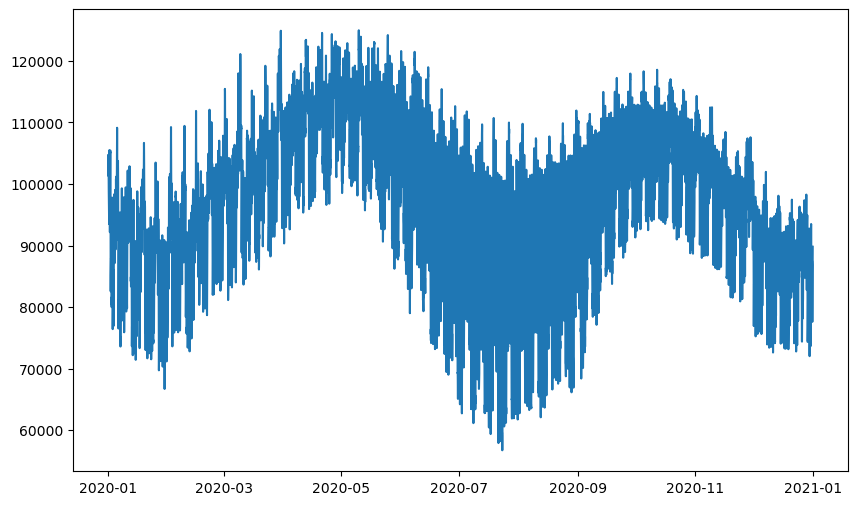

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df_stoc['excess'])

In [31]:
elcc = run_energy_system(base_system_scratch, perfect_system_scratch, class_system_scratch, 2012, trial_size_input = 1)

In [32]:
elcc

0

In [ ]:
for i in range(2012,2024):
    pow_gen_dataset = xr.open_dataset(Path(power_gen_data_folder/f'pjm_power_generation_{weather_year}.nc'))


In [ ]:
elcc_reslts = {}

for i in range(2026,2040):
    print("Running year: ", i)
    thermal_file = Path(gen_data_folder / ('thermal_{year}.csv').format(year=i)) 
    solar_file = Path(gen_data_folder / ('solar_{year}.csv').format(year=i))
    wind_file = Path(gen_data_folder / ('wind_{year}.csv').format(year=i))
    storage_file = Path(gen_data_folder / ('batteries_{year}.csv').format(year=i))
    gen_file_storage_previous_year = Path(gen_data_folder / ('batteries_{year}.csv').format(year=i-1))
    demand_file = Path(load_forecast_folder / ('combined_load_{year}.csv').format(year=i))

    new_class, new_class_size = determine_new_class(storage_file, gen_file_storage_previous_year)

    elcc_values = []

    for i in range(2012,2024):
        print("Running weather simulation: ", i)
        weather_year = i
        pow_gen_dataset = xr.open_dataset(Path(power_gen_data_folder/f'pjm_power_generation_{weather_year}.nc'))

        start_hour = "{}-01-01 00:00:00".format(weather_year)
        end_hour = "{}-12-31 23:00:00".format(weather_year)

        base_system_scratch = load_base_energy_system(demand_file, weather_year, thermal_file, solar_file, wind_file, storage_file, pow_gen_dataset)
        class_system_scratch = load_class_energy_system(demand_file, weather_year, thermal_file, solar_file, wind_file, storage_file, pow_gen_dataset, new_class)
        perfect_system_scratch = load_perfect_energy_system(demand_file, weather_year, thermal_file, solar_file, wind_file, storage_file, pow_gen_dataset, new_class_size)
        

        elcc = run_energy_system(base_system_scratch, perfect_system_scratch, class_system_scratch, weather_year, trial_size_input = 10)

        elcc_values.append(elcc)
    
    elcc_avg = np.mean(elcc_values)

    elcc_reslts[i] = elcc_avg
    
    

Running year:  2026
Running weather simulation:  2012
Running weather simulation:  2013


KeyboardInterrupt: 